In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8683 - acc: 0.4417
Epoch 00001: val_loss improved from inf to 1.57015, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_4_conv_checkpoint/001-1.5702.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.8683 - acc: 0.4417 - val_loss: 1.5702 - val_acc: 0.5057
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2013 - acc: 0.6376
Epoch 00002: val_loss improved from 1.57015 to 1.26658, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_4_conv_checkpoint/002-1.2666.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.2013 - acc: 0.6376 - val_loss: 1.2666 - val_acc: 0.6238
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9541 - acc: 0.7132
Epoch 00003: val_loss improved from 1.26658 to 1.20449, saving mode

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9946
Epoch 00028: val_loss did not improve from 1.11438
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0429 - acc: 0.9945 - val_loss: 1.5391 - val_acc: 0.6841
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9926
Epoch 00029: val_loss did not improve from 1.11438
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0470 - acc: 0.9925 - val_loss: 1.5452 - val_acc: 0.6990
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9935
Epoch 00030: val_loss did not improve from 1.11438
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0433 - acc: 0.9934 - val_loss: 1.5953 - val_acc: 0.6697
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9917
Epoch 00031: val_loss did not improve from 1.11438
36805/36805 [===========


1D_CNN_custom_4_ch_64_BN_4_conv Model


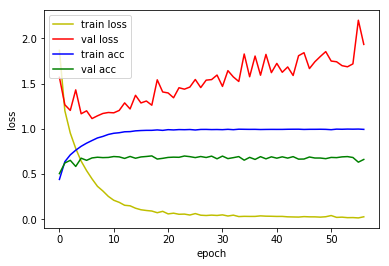

4815/4815 [==============================] - 4s 887us/sample - loss: 1.2374 - acc: 0.6426
Loss: 1.2374102445901491 Accuracy: 0.64257526

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9009 - acc: 0.4162
Epoch 00001: val_loss improved from inf to 1.56035, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_5_conv_checkpoint/001-1.5603.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.9008 - acc: 0.4162 - val_loss: 1.5603 - val_acc: 0.5015
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2525 - acc: 0.6199
Epoch 00002: val_loss improved from 1.56035 to 1.13491, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_5_conv_checkpoint/002-1.1349.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2526 - acc: 0.6198 - val_loss: 1.1349 - val_acc: 0.6557
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9373
Epoch 00027: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2319 - acc: 0.9372 - val_loss: 0.8565 - val_acc: 0.7687
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9419
Epoch 00028: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2198 - acc: 0.9419 - val_loss: 0.9335 - val_acc: 0.7582
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9455
Epoch 00029: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2054 - acc: 0.9455 - val_loss: 0.9264 - val_acc: 0.7447
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9490
Epoch 00030: val_loss did not improve from 0.77204
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9882
Epoch 00057: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0628 - acc: 0.9882 - val_loss: 1.0593 - val_acc: 0.7654
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9874
Epoch 00058: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0647 - acc: 0.9873 - val_loss: 1.3041 - val_acc: 0.7186
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9829
Epoch 00059: val_loss did not improve from 0.77204
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0772 - acc: 0.9829 - val_loss: 1.1972 - val_acc: 0.7461
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9889
Epoch 00060: val_loss did not improve from 0.77204
36805/36805 [===========

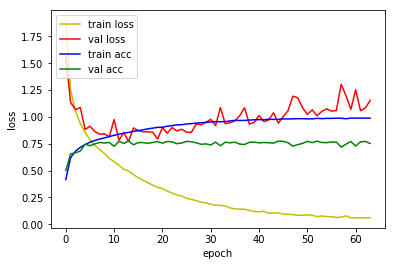

4815/4815 [==============================] - 4s 917us/sample - loss: 0.8586 - acc: 0.7373
Loss: 0.8586242485021629 Accuracy: 0.73727936

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1032 - acc: 0.3497
Epoch 00001: val_loss improved from inf to 1.69012, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_6_conv_checkpoint/001-1.6901.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.1031 - acc: 0.3497 - val_loss: 1.6901 - val_acc: 0.4631
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3971 - acc: 0.5654
Epoch 00002: val_loss improved from 1.69012 to 1.21012, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_6_conv_checkpoint/002-1.2101.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.3973 - acc: 0.5653 - val_loss: 1.2101 - val_acc: 0.6366
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.3661 - acc: 0.8942
Epoch 00025: val_loss improved from 0.55617 to 0.55184, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_6_conv_checkpoint/025-0.5518.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3661 - acc: 0.8942 - val_loss: 0.5518 - val_acc: 0.8491
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.8988
Epoch 00026: val_loss did not improve from 0.55184
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3495 - acc: 0.8988 - val_loss: 0.6136 - val_acc: 0.8281
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.9010
Epoch 00027: val_loss did not improve from 0.55184
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3494 - acc: 0.9010 - val_loss: 0.6248 - val_acc: 0.8395
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3291 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.1597 - acc: 0.9567
Epoch 00052: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1599 - acc: 0.9567 - val_loss: 0.5472 - val_acc: 0.8530
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1595 - acc: 0.9561
Epoch 00053: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1598 - acc: 0.9560 - val_loss: 0.5711 - val_acc: 0.8521
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9580
Epoch 00054: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1537 - acc: 0.9580 - val_loss: 0.5220 - val_acc: 0.8642
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1433 - acc: 0.9620
Epoch 00055: val_loss did not improve from 0.50301
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0774 - acc: 0.9815
Epoch 00082: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0775 - acc: 0.9815 - val_loss: 0.7000 - val_acc: 0.8465
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9797
Epoch 00083: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0811 - acc: 0.9797 - val_loss: 0.5742 - val_acc: 0.8637
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9820
Epoch 00084: val_loss did not improve from 0.50301
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0760 - acc: 0.9819 - val_loss: 0.6170 - val_acc: 0.8579
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9782
Epoch 00085: val_loss did not improve from 0.50301
36805/36805 [===========

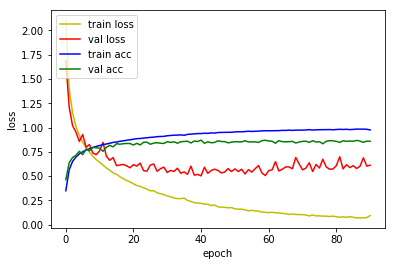

4815/4815 [==============================] - 4s 894us/sample - loss: 0.5741 - acc: 0.8363
Loss: 0.574137274684193 Accuracy: 0.8363448

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6384 - acc: 0.1993
Epoch 00001: val_loss improved from inf to 2.18367, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_7_conv_checkpoint/001-2.1837.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.6384 - acc: 0.1993 - val_loss: 2.1837 - val_acc: 0.3284
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8648 - acc: 0.4183
Epoch 00002: val_loss improved from 2.18367 to 1.65732, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_7_conv_checkpoint/002-1.6573.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.8647 - acc: 0.4183 - val_loss: 1.6573 - val_acc: 0.4948
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4187 - acc: 0.8783
Epoch 00025: val_loss did not improve from 0.44411
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.4187 - acc: 0.8783 - val_loss: 0.5021 - val_acc: 0.8581
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4065 - acc: 0.8819
Epoch 00026: val_loss did not improve from 0.44411
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.4066 - acc: 0.8819 - val_loss: 0.4520 - val_acc: 0.8768
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3943 - acc: 0.8864
Epoch 00027: val_loss did not improve from 0.44411
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3946 - acc: 0.8863 - val_loss: 0.5160 - val_acc: 0.8507
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3878 - acc: 0.8890
Epoch 00028: val_loss did not improve from 0.44411
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2218 - acc: 0.9340
Epoch 00053: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2220 - acc: 0.9339 - val_loss: 0.3935 - val_acc: 0.8935
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2162 - acc: 0.9350
Epoch 00054: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2162 - acc: 0.9350 - val_loss: 0.3791 - val_acc: 0.8970
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2071 - acc: 0.9387
Epoch 00055: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2071 - acc: 0.9387 - val_loss: 0.3796 - val_acc: 0.8912
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2055 - acc: 0.9392
Epoch 00056: val_loss did not improve from 0.37240
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9626
Epoch 00083: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1300 - acc: 0.9626 - val_loss: 0.4562 - val_acc: 0.8961
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9646
Epoch 00084: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1217 - acc: 0.9646 - val_loss: 0.4372 - val_acc: 0.8870
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9646
Epoch 00085: val_loss did not improve from 0.37240
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1200 - acc: 0.9646 - val_loss: 0.4241 - val_acc: 0.8945
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9646
Epoch 00086: val_loss did not improve from 0.37240
36805/36805 [===========

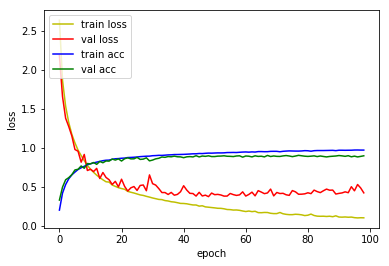

4815/4815 [==============================] - 4s 925us/sample - loss: 0.4625 - acc: 0.8654
Loss: 0.46254912905727713 Accuracy: 0.8654206

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6495 - acc: 0.1919
Epoch 00001: val_loss improved from inf to 2.37974, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_8_conv_checkpoint/001-2.3797.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 2.6495 - acc: 0.1919 - val_loss: 2.3797 - val_acc: 0.2485
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9657 - acc: 0.3861
Epoch 00002: val_loss improved from 2.37974 to 1.68574, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_8_conv_checkpoint/002-1.6857.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.9657 - acc: 0.3861 - val_loss: 1.6857 - val_acc: 0.4775
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3479 - acc: 0.8996
Epoch 00025: val_loss did not improve from 0.34717
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3481 - acc: 0.8996 - val_loss: 0.3720 - val_acc: 0.8915
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3338 - acc: 0.9033
Epoch 00026: val_loss did not improve from 0.34717
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3338 - acc: 0.9032 - val_loss: 0.3552 - val_acc: 0.9036
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3226 - acc: 0.9068
Epoch 00027: val_loss did not improve from 0.34717
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3226 - acc: 0.9068 - val_loss: 0.3667 - val_acc: 0.8915
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3132 - acc: 0.9089
Epoch 00028: val_loss did not improve from 0.34717
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1754 - acc: 0.9474
Epoch 00053: val_loss did not improve from 0.27682
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1754 - acc: 0.9474 - val_loss: 0.2893 - val_acc: 0.9180
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1725 - acc: 0.9491
Epoch 00054: val_loss did not improve from 0.27682
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1727 - acc: 0.9491 - val_loss: 0.2854 - val_acc: 0.9250
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9528
Epoch 00055: val_loss did not improve from 0.27682
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1587 - acc: 0.9528 - val_loss: 0.3007 - val_acc: 0.9147
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9526
Epoch 00056: val_loss did not improve from 0.27682
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9666
Epoch 00082: val_loss did not improve from 0.27196
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1129 - acc: 0.9666 - val_loss: 0.3014 - val_acc: 0.9161
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9675
Epoch 00083: val_loss did not improve from 0.27196
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1068 - acc: 0.9675 - val_loss: 0.3200 - val_acc: 0.9126
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9725
Epoch 00084: val_loss did not improve from 0.27196
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0923 - acc: 0.9724 - val_loss: 0.2897 - val_acc: 0.9185
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9733
Epoch 00085: val_loss did not improve from 0.27196
36805/36805 [========================

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9834
Epoch 00112: val_loss did not improve from 0.27196
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0593 - acc: 0.9834 - val_loss: 0.3128 - val_acc: 0.9203
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9847
Epoch 00113: val_loss did not improve from 0.27196
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0573 - acc: 0.9846 - val_loss: 0.3249 - val_acc: 0.9161
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9789
Epoch 00114: val_loss did not improve from 0.27196
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0700 - acc: 0.9789 - val_loss: 0.3512 - val_acc: 0.9140
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9814
Epoch 00115: val_loss did not improve from 0.27196
36805/36805 [=======

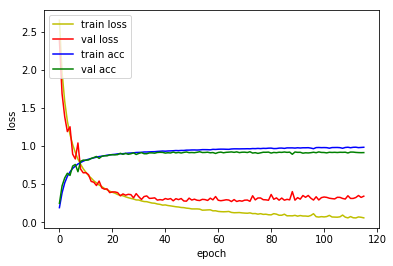

4815/4815 [==============================] - 5s 988us/sample - loss: 0.3589 - acc: 0.9022
Loss: 0.3588696733380156 Accuracy: 0.9021807

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5289 - acc: 0.2202
Epoch 00001: val_loss improved from inf to 2.27535, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_9_conv_checkpoint/001-2.2754.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.5287 - acc: 0.2203 - val_loss: 2.2754 - val_acc: 0.2895
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8754 - acc: 0.4136
Epoch 00002: val_loss improved from 2.27535 to 1.62337, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_9_conv_checkpoint/002-1.6234.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.8754 - acc: 0.4137 - val_loss: 1.6234 - val_acc: 0.5120
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3314 - acc: 0.9023
Epoch 00023: val_loss improved from 0.35502 to 0.35331, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_9_conv_checkpoint/023-0.3533.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3314 - acc: 0.9022 - val_loss: 0.3533 - val_acc: 0.8952
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3178 - acc: 0.9071
Epoch 00024: val_loss improved from 0.35331 to 0.34279, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_9_conv_checkpoint/024-0.3428.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3179 - acc: 0.9070 - val_loss: 0.3428 - val_acc: 0.8959
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3104 - acc: 0.9077
Epoch 00025: val_loss improved from 0.34279 to 0.31432, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_BN_9_conv_checkpoint/025-0.3143.hdf5
36805/368

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1727 - acc: 0.9483
Epoch 00049: val_loss did not improve from 0.26239
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1728 - acc: 0.9483 - val_loss: 0.2661 - val_acc: 0.9208
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1615 - acc: 0.9511
Epoch 00050: val_loss did not improve from 0.26239
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1616 - acc: 0.9510 - val_loss: 0.2674 - val_acc: 0.9196
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1648 - acc: 0.9508
Epoch 00051: val_loss did not improve from 0.26239
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1650 - acc: 0.9508 - val_loss: 0.2833 - val_acc: 0.9159
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9504
Epoch 00052: val_loss did not improve from 0.26239
36805/36805 [===========

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9729
Epoch 00078: val_loss did not improve from 0.25140
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0917 - acc: 0.9728 - val_loss: 0.2828 - val_acc: 0.9238
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9718
Epoch 00079: val_loss did not improve from 0.25140
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0939 - acc: 0.9717 - val_loss: 0.2961 - val_acc: 0.9238
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9685
Epoch 00080: val_loss did not improve from 0.25140
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1015 - acc: 0.9685 - val_loss: 0.2764 - val_acc: 0.9266
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 - acc: 0.9719
Epoch 00081: val_loss did not improve from 0.25140
36805/36805 [===========

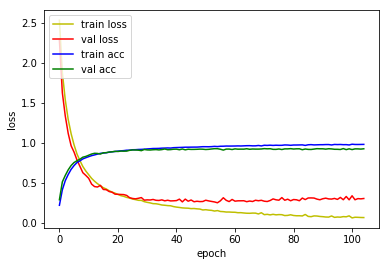

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3331 - acc: 0.9067
Loss: 0.3330987807065403 Accuracy: 0.9067497



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_64_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_64_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5741 - acc: 0.8363
Loss: 0.574137274684193 Accuracy: 0.8363448

1D_CNN_custom_4_ch_64_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 1

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3589 - acc: 0.9022
Loss: 0.3588696733380156 Accuracy: 0.9021807

1D_CNN_custom_4_ch_64_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.7174 - acc: 0.8359
Loss: 0.7174327435399389 Accuracy: 0.8359294

1D_CNN_custom_4_ch_64_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4245 - acc: 0.8968
Loss: 0.4245051181305544 Accuracy: 0.8967809

1D_CNN_custom_4_ch_64_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 